Highest diameter: 598
Centerx: 300 and Centery: 359
Total lines detected: 45
Lines near center: 3
Lines near center (coordinates):
Line 1: (331, 326) to (434, 268)
Line 2: (338, 314) to (433, 260)
Line 3: (225, 284) to (292, 331)
Number of lines detected at the beginning: 3


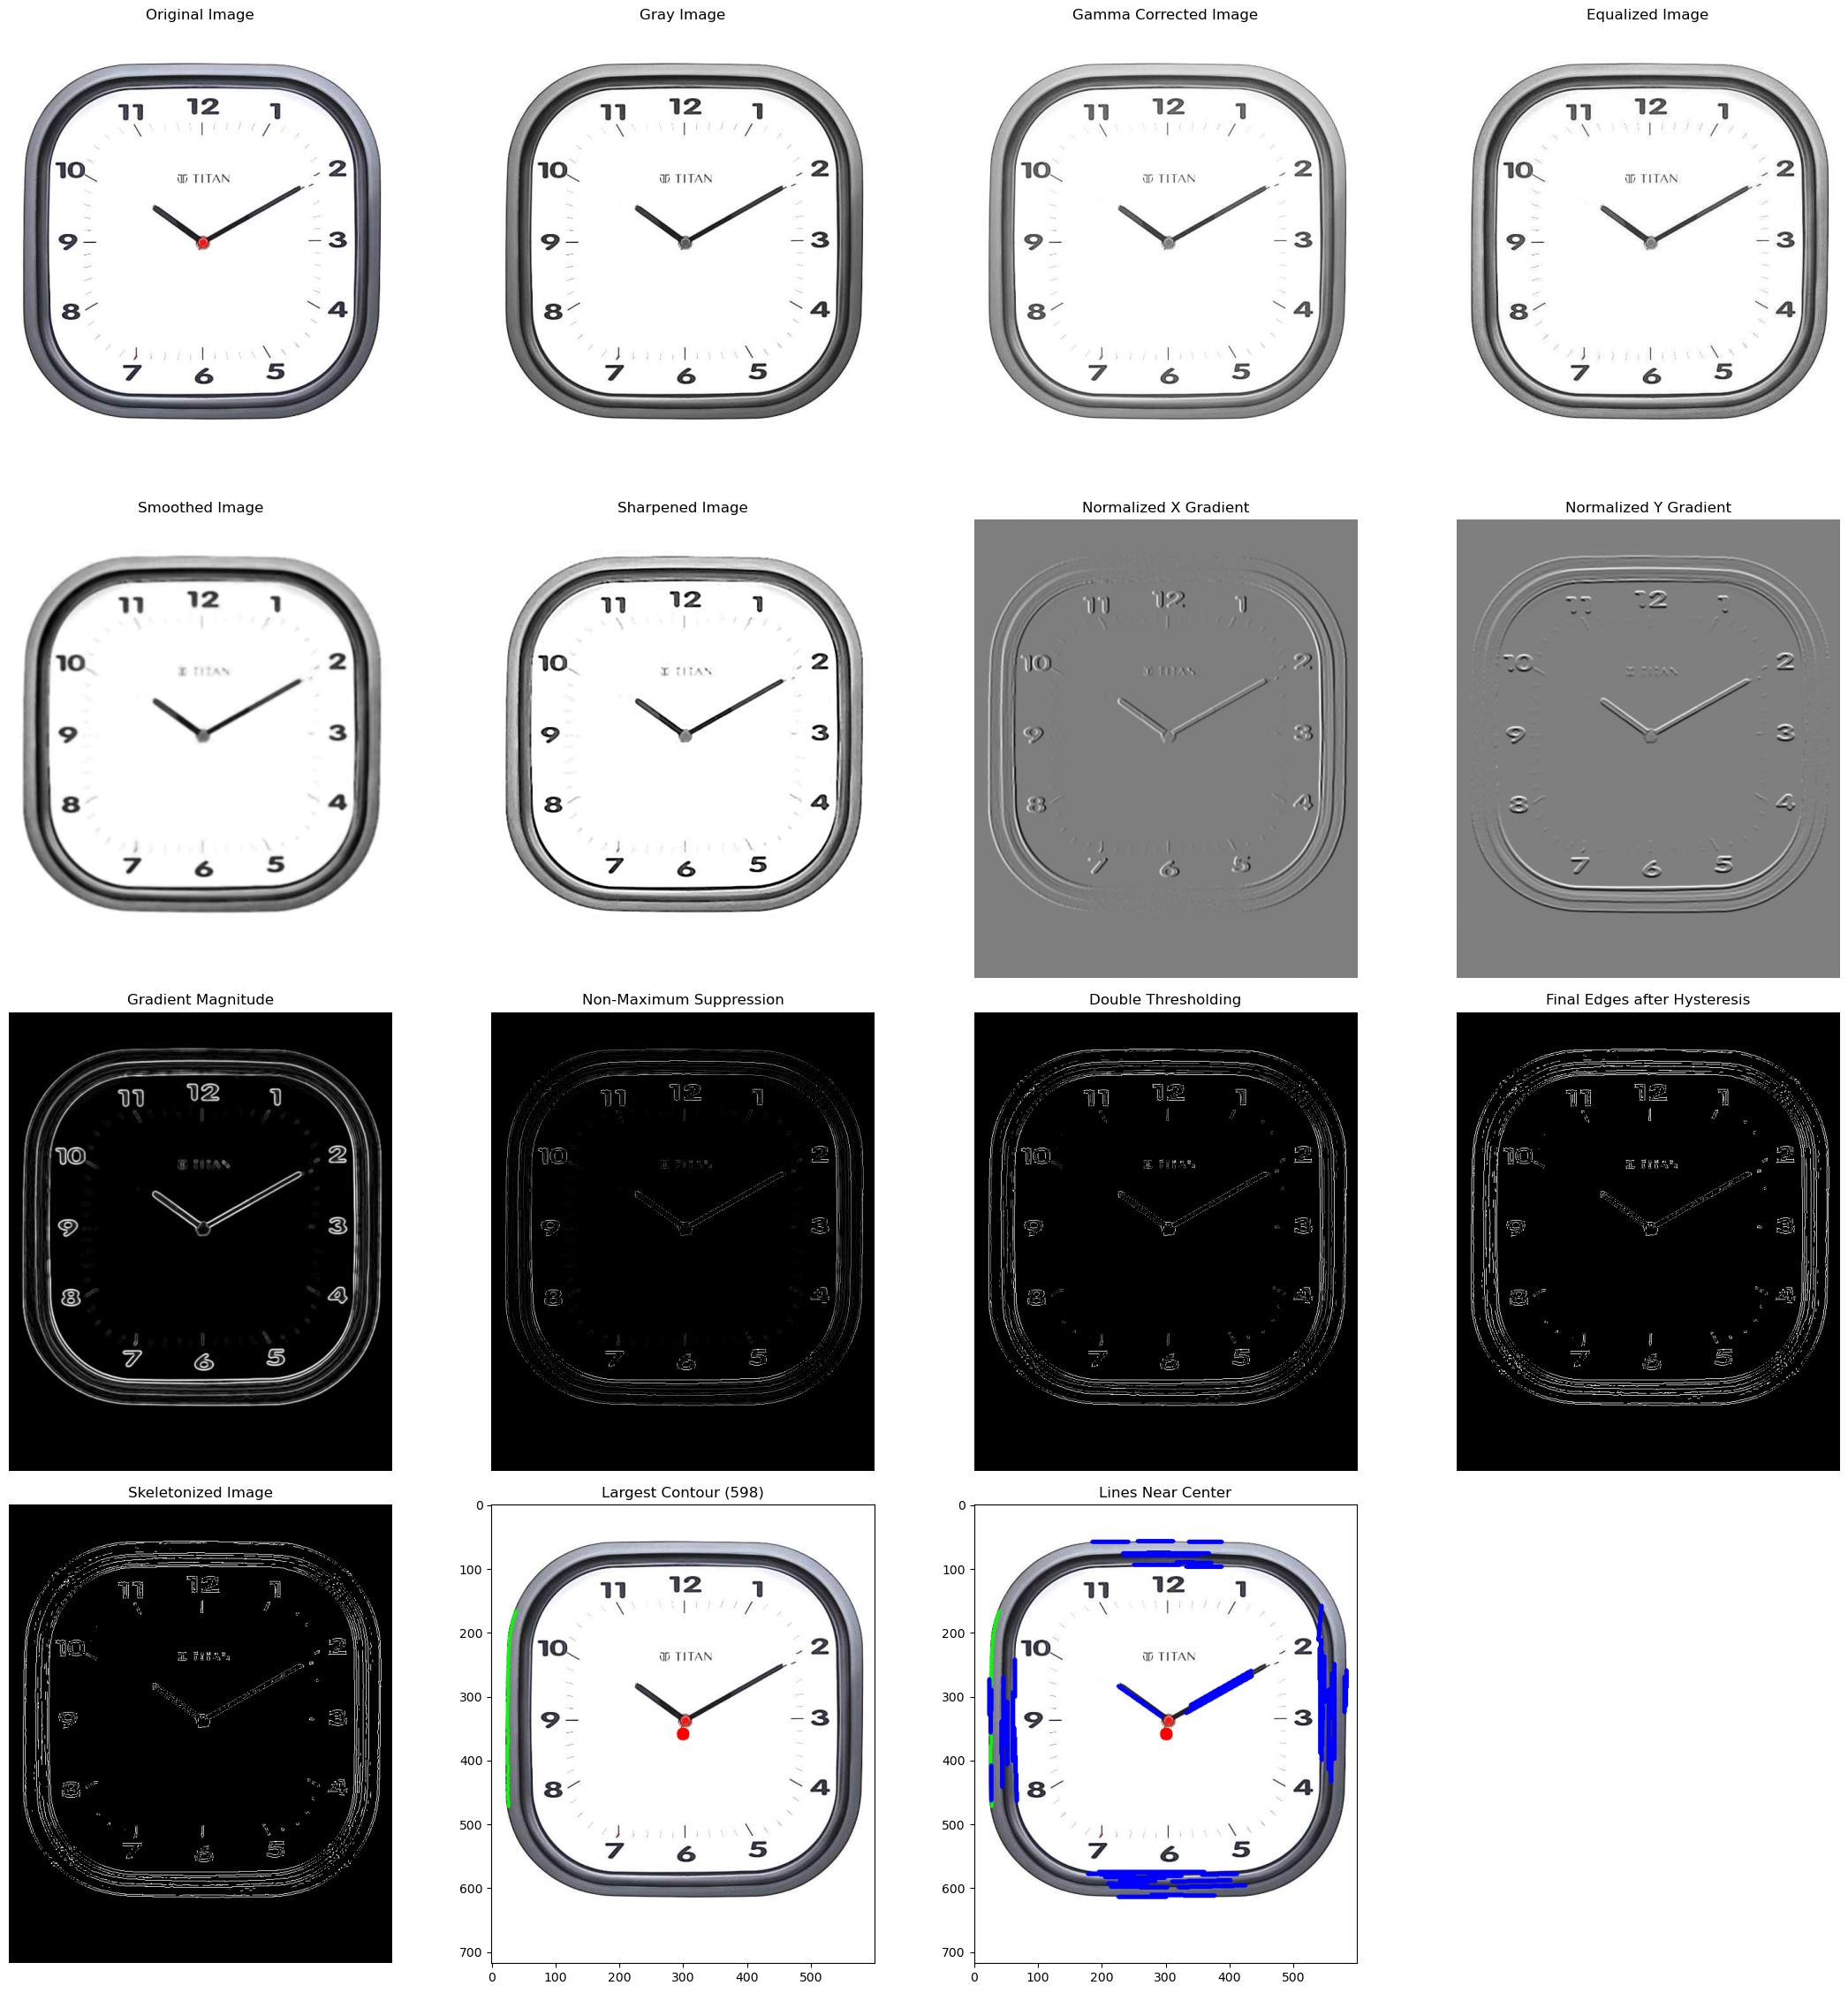

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Failed to load image.")
        return None
    return image

def gamma_correction(image, gamma):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype(np.uint8)
    return cv2.LUT(image, table)

# def Manual_equalizeHist(image):
#     M,N = image.shape
#     total_pixels = M * N
#     L = 256
#     histogram = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    
#     probability = np.zeros(L, dtype=np.float32)
#     for i in range(L):
#         probability[i] = histogram[i] / total_pixels
        
#     cum_sum_array = np.zeros(L, dtype=np.float32)
#     trans_func = np.zeros(L, dtype=np.float32)
#     for i in range(L):
#         cum_sum = 0.0
#         for j in range(i+1):
#             cum_sum += probability[j]
#         cum_sum_array[i] = cum_sum
#         trans_func[i] = (L-1) * cum_sum_array[i]
#         if trans_func[i] > 255:
#             trans_func[i] = 255
            
#     equalized_img = cv2.LUT(image, trans_func.astype(np.uint8))
#     return histogram, probability, cum_sum_array, trans_func, equalized_img

def clahe_equalize(image):
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab_eq = cv2.merge((cl, a, b))
    equalized_img = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2BGR)
    gray_eq = cv2.cvtColor(equalized_img, cv2.COLOR_BGR2GRAY)
    return gray_eq

def plot_histogram(img, title, pos):
    plt.subplot(2, 3, pos)
    plt.hist(img.ravel(), bins=256, range=[0, 256], color='black')
    plt.title(title)
    plt.xlabel('Pixel value')
    plt.ylabel('Frequency')
    
def smoothing(image):
    smoothed = cv2.medianBlur(image, 5) 
    smoothed = cv2.bilateralFilter(smoothed, 100, 2, 2)
    smoothed = cv2.GaussianBlur(smoothed, (5,5), 0)
    return smoothed

def increase_sharpness(image):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharp_image = cv2.filter2D(image, -1, kernel)
    return sharp_image

def gaussianFunction(x,y,sigma):
    return (1/(2*np.pi*sigma**2))*np.exp(-(x**2 + y**2) /(2*sigma**2))

def gaussianKernel_x(size, sigma):
    k = size // 2
    coords = np.arange(-k, k + 1)
    x,y = np.meshgrid(coords, coords)
    gaussval = gaussianFunction(x, y, sigma)
    kernel = -(x / sigma**2) * gaussval
    kernel /= np.sum(np.abs(kernel))
    return kernel

def gaussianKernel_y(size, sigma):
    k = size // 2
    coords = np.arange(-k, k + 1)
    x,y = np.meshgrid(coords, coords)
    gaussval = gaussianFunction(x, y, sigma)
    kernel = -(y / sigma**2) * gaussval
    kernel /= np.sum(np.abs(kernel))
    return kernel

def non_maximum_suppression(grad_mag, angle):
    M, N = grad_mag.shape
    Z = np.zeros((M,N), dtype=np.uint8)
    angle = angle * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            q = 255
            r = 255
            
            # Angle 0
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                q = grad_mag[i, j+1]
                r = grad_mag[i, j-1]
            # Angle 45
            elif (22.5 <= angle[i,j] < 67.5):
                q = grad_mag[i-1, j+1]
                r = grad_mag[i+1, j-1]
            # Angle 90
            elif (67.5 <= angle[i,j] < 112.5):
                q = grad_mag[i-1, j]
                r = grad_mag[i+1, j]
            # Angle 135
            elif (112.5 <= angle[i,j] < 157.5):
                q = grad_mag[i-1, j-1]
                r = grad_mag[i+1, j+1]

            if (grad_mag[i,j] >= q) and (grad_mag[i,j] >= r):
                Z[i,j] = grad_mag[i,j]
            else:
                Z[i,j] = 0

    return Z

def double_threshold(image, low_thresh, high_thresh, mid_val):
    output = np.zeros_like(image, dtype=np.uint8)
    output[image >= high_thresh] = 255
    output[image < low_thresh] = 0
    mask = (image >= low_thresh) & (image < high_thresh)
    output[mask] = mid_val
    return output


def hysteresis_thresholding(image, low_thresh, high_thresh, strong_val, weak_val):
    strong_pixel_val = strong_val
    weak_pixel_val = weak_val
    output = np.zeros_like(image, dtype=np.uint8)
    strong_pixels = image >= high_thresh
    weak_pixels = (image < high_thresh) & (image >= low_thresh)
    output[strong_pixels] = strong_pixel_val
    output[weak_pixels] = weak_pixel_val
    pad_output = np.pad(output, 1, mode='constant', constant_values=0)
    rows, cols = image.shape
    for _ in range(20):
        for r in range(rows):
            for c in range(cols):
                pr, pc = r+1, c+1
                if pad_output[pr, pc] == weak_pixel_val:
                    if np.max(pad_output[pr-1:pr+2, pc-1:pc+2]) == strong_pixel_val:
                        pad_output[pr, pc] = strong_pixel_val
    output = pad_output[1:-1, 1:-1]
    output[output == weak_pixel_val] = 0
    return output

def skeletonize(image):
    size = np.size(image)
    skel = np.zeros(image.shape, np.uint8)

    ret, img = cv2.threshold(image, 127, 255, 0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False

    while not done:
        eroded = cv2.erode(img, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(img, temp)
        skel = cv2.bitwise_or(skel, temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros == size:
            done = True
    return skel

def distance(pt1, pt2):
    return np.sqrt((pt1[0]-pt2[0])**2 + (pt1[1]-pt2[1])**2)

def find_largest_contour_center(image, skeleton):
    contours, hierarchy = cv2.findContours(skeleton, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour assuming it is the clock face
    max_contour = max(contours, key=cv2.contourArea)

    # Draw for visualization
    image_contour = image.copy()
    cv2.drawContours(image_contour, [max_contour], -1, (0, 255, 0), 3)

    # Calculate centroid of largest contour
    M = cv2.moments(max_contour)
    highest_diameter = 0

    if M['m00'] == 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            leftmost = tuple(max_contour[max_contour[:,:,0].argmin()][0])
            rightmost = tuple(max_contour[max_contour[:,:,0].argmax()][0])
            topmost = tuple(max_contour[max_contour[:,:,1].argmin()][0])
            bottommost = tuple(max_contour[max_contour[:,:,1].argmax()][0])
            highest_diameter = max(distance(leftmost, rightmost), distance(topmost, bottommost))
    else:
            cx = image.shape[1] // 2
            cy = image.shape[0] // 2
            highest_diameter = image.shape[0] *5 // 6
    diameter_text = f"Highest diameter: {highest_diameter}"
    print(f"Highest diameter: {highest_diameter}")


    # draw center of the contour on the gray image with red color
    cv2.circle(image_contour, (cx, cy), 10, (0,0,255), -1)
    #cv2.imwrite("center.jpg", image)
    center_text = f"Center: ({cx}, {cy})"
    print(f"Centerx: {cx} and Centery: {cy}")
    
    return image_contour, (cx, cy), highest_diameter

def detect_and_draw_hough_lines(image, edge_img, rho, theta, threshold, min_line_length, max_line_gap):

    # Copies of the image to draw lines on
    all_lines_image = image.copy()
    center_lines_image = image.copy()

    # Detect lines using Hough Line Transform on the provided edge image
    lines = cv2.HoughLinesP(
        edge_img,
        rho,
        theta,
        threshold,
        np.array([]),
        minLineLength=min_line_length,
        maxLineGap=max_line_gap,
    )

    actual_lines = []

    # Early return if no lines detected
    if lines is None:
        print("Total lines detected: 0")
        print("Lines near center: 0")
        return all_lines_image, center_lines_image, actual_lines

    # Draw all detected lines (for visualization)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(all_lines_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

    # Filter lines based on proximity to the center
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2
    for line in lines:
        for x1, y1, x2, y2 in line:
            if (
                math.hypot(x1 - center_x, y1 - center_y) < 60
                or math.hypot(x2 - center_x, y2 - center_y) < 60
            ):
                actual_lines.append(line)

    # Draw only the filtered lines on the output image
    for line in actual_lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(center_lines_image, (x1, y1), (x2, y2), (255, 0, 0), 5)

    print(f"Total lines detected: {len(lines)}")
    print(f"Lines near center: {len(actual_lines)}")

    print("Lines near center (coordinates):")
    for idx, line in enumerate(actual_lines):
        x1, y1, x2, y2 = line[0]
        print(f"Line {idx+1}: ({x1}, {y1}) to ({x2}, {y2})")

    count = len(actual_lines)
    print(f"Number of lines detected at the beginning: {count}")

    return all_lines_image, center_lines_image, actual_lines







image_path = 'input images/input5.jpg'
image = load_image(image_path)
if image is None:
    exit()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gamma = 1.5
gamma_corrected = gamma_correction(gray, gamma)
gamma_corrected_bgr = cv2.cvtColor(gamma_corrected, cv2.COLOR_GRAY2BGR)

# hist, prob, cdf, trans, eq_img = Manual_equalizeHist(gray)

equalized_img = clahe_equalize(gamma_corrected_bgr)

smoothed = smoothing(equalized_img)
sharp = increase_sharpness(smoothed)

sigma = 1
size = 5
kernel_x = gaussianKernel_x(size, sigma)
kernel_y = gaussianKernel_y(size, sigma)

convo_x = cv2.filter2D(sharp, cv2.CV_32F, kernel_x)
convo_y = cv2.filter2D(sharp, cv2.CV_32F, kernel_y)

norm_x = cv2.normalize(convo_x, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
norm_y = cv2.normalize(convo_y, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# grad_mag = np.sqrt(convo_x**2 + convo_y**2)
# grad_mag = cv2.normalize(grad_mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

gradient_mag = cv2.magnitude(convo_x.astype(np.float32), convo_y.astype(np.float32) )
grad_norm = np.round(cv2.normalize(gradient_mag, None, 0, 255, cv2.NORM_MINMAX)).astype(np.uint8)

# angle = np.arctan2(convo_y, convo_x) * 180 / np.pi
grad_angle = np.arctan2(convo_y, convo_x)

nms_img = non_maximum_suppression(grad_norm, grad_angle)

low_threshold = 30
high_threshold = 80
mid_value = 128

dt_img = double_threshold(nms_img, low_threshold, high_threshold, mid_value)
final_edges = hysteresis_thresholding(dt_img, low_threshold, high_threshold, 255, 75)  

skeleton = skeletonize(final_edges)

image_contour, center, diameter = find_largest_contour_center(image, skeleton)

# Define parameters for Hough Line Transform
rho = 1
theta = np.pi / 180
threshold = 10
min_line_length = 50
max_line_gap = 7

all_lines_img, center_lines_img, filtered_lines = detect_and_draw_hough_lines(image_contour, skeleton, rho, theta, threshold, min_line_length, max_line_gap)








plt.figure(figsize=(22, 28))
plt.subplot(5, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(5, 4, 2)
plt.imshow(gray, cmap='gray')
plt.title('Gray Image')
plt.axis('off')

plt.subplot(5, 4, 3)
plt.imshow(gamma_corrected_bgr, cmap='gray')
plt.title('Gamma Corrected Image')
plt.axis('off')

plt.subplot(5, 4, 4)
plt.imshow(equalized_img, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')

# plot_histogram(gray, 'Original Histogram', 5)
# plot_histogram(equalized_img, 'Equalized Histogram', 6)

plt.subplot(5, 4, 5)
plt.imshow(smoothed, cmap='gray')
plt.title('Smoothed Image')
plt.axis('off')

plt.subplot(5, 4, 6)
plt.imshow(sharp, cmap='gray')
plt.title('Sharpened Image')
plt.axis('off')

plt.subplot(5, 4, 7)
plt.imshow(norm_x, cmap='gray')
plt.title('Normalized X Gradient')
plt.axis('off')

plt.subplot(5, 4, 8)
plt.imshow(norm_y, cmap='gray')
plt.title('Normalized Y Gradient')
plt.axis('off')

plt.subplot(5, 4, 9)
plt.imshow(gradient_mag, cmap='gray')
plt.title('Gradient Magnitude')
plt.axis('off') 

plt.subplot(5, 4, 10)
plt.imshow(nms_img, cmap='gray')
plt.title('Non-Maximum Suppression')
plt.axis('off') 

plt.subplot(5, 4, 11)
plt.imshow(dt_img, cmap='gray')
plt.title('Double Thresholding')
plt.axis('off')

plt.subplot(5, 4, 12)
plt.imshow(final_edges, cmap='gray')
plt.title('Final Edges after Hysteresis')
plt.axis('off')

plt.subplot(5, 4, 13)
plt.imshow(skeleton, cmap='gray')
plt.title('Skeletonized Image')
plt.axis('off')

plt.subplot(5, 4, 14)
plt.imshow(cv2.cvtColor(image_contour, cv2.COLOR_BGR2RGB))
plt.title(f'Largest Contour ({diameter})')

plt.subplot(5, 4, 15)
plt.imshow(cv2.cvtColor(all_lines_img, cv2.COLOR_BGR2RGB))
plt.title('All Hough Lines')

plt.subplot(5, 4, 16)
plt.imshow(cv2.cvtColor(center_lines_img, cv2.COLOR_BGR2RGB))
plt.title('Lines Near Center')

plt.tight_layout()
plt.show()